In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

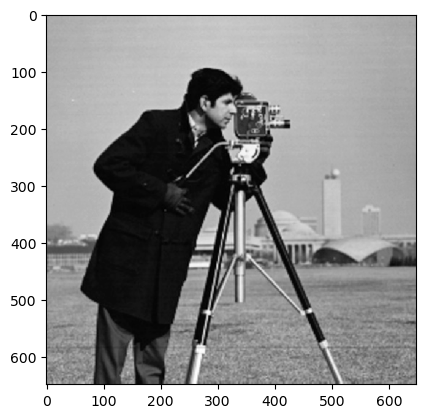

In [3]:
image = cv2.imread(r"C:\Users\RASHAD KP\Desktop\The-cameraman-picture-with-256-256-size.png")
image = image[:,:,0]
plt.imshow(image,cmap='gray')
plt.show()

In [24]:
def conv2d(image,kernel):
    width, height = image.shape
    padded_image = np.zeros((width+2*(kernel.shape[0]//2), height+2*(kernel.shape[0]//2) ))
    k = kernel.shape[0]//2
    padded_image[k:-k,k:-k] = image
    output_image = np.zeros((width, height))
    for i in range(width):
        for j in range(height):
            output_image[i,j] = (kernel * padded_image[i:i+kernel.shape[0],j:j+kernel.shape[0]]).sum()
    plt.imshow(output_image,cmap='gray')
    plt.show()
    return output_image


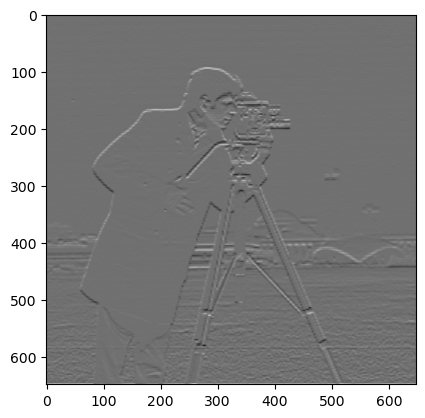

In [5]:
prewitt_x =  np.array([[ 1,   1,   1],
                       [ 0,   0,   0],
                       [-1,  -1,  -1]])
hor_edge_prewitt = conv2d(image,prewitt_x)

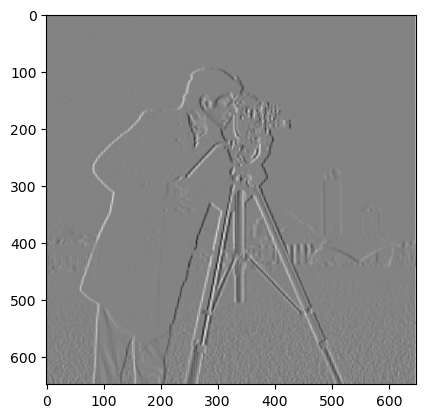

In [6]:
prewitt_y =  np.array([[ 1,   0,   -1],
                       [ 1,   0,   -1],
                       [ 1,   0,   -1]])
ver_edge_prewitt = conv2d(image,prewitt_y)

In [7]:
def hor_ver_combined(horizontal,vertical):
    edge = np.zeros_like(horizontal)
    for i in range(horizontal.shape[0]):
        for j in range(horizontal.shape[1]):
            edge[i,j] = (horizontal[i,j]**2 + vertical[i,j]**2)**0.5

    return edge



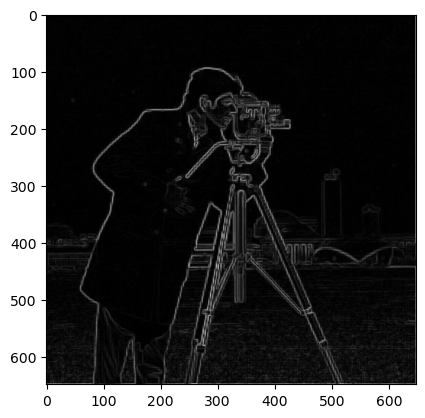

In [8]:
prewitt = hor_ver_combined(hor_edge_prewitt,ver_edge_prewitt)

plt.imshow(prewitt,cmap= 'gray')
plt.show()

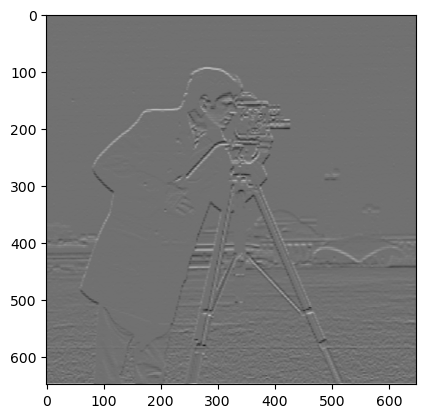

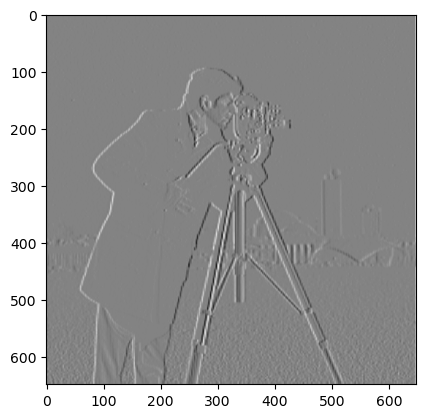

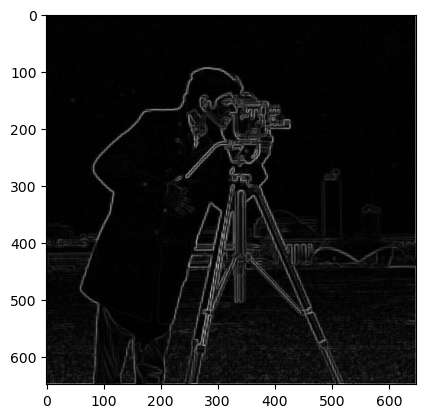

In [9]:
sobel_x =  np.array([[ 1,   2,   1],
                       [ 0,   0,   0],
                       [-1,  -2,  -1]])
hor_edge_sobel = conv2d(image,sobel_x)
sobel_y =  np.array([[ 1,   0,   -1],
                       [ 2,   0,   -2],
                       [ 1,   0,   -1]])
ver_edge_sobel = conv2d(image,sobel_y)

sobel = hor_ver_combined(hor_edge_sobel, ver_edge_sobel)

plt.imshow(sobel,cmap= 'gray')
plt.show()

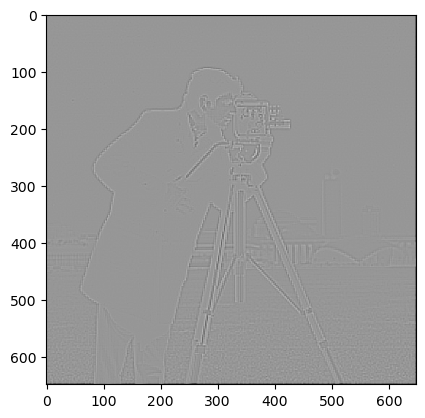

In [10]:
laplacian =  np.array([[ 1,   1,   1],
                       [ 1,   -8,   1],
                       [ 1,   1,   1]])
laplace = conv2d(image,laplacian)

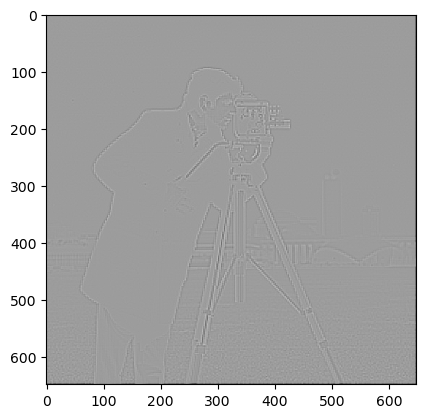

In [11]:
laplacian =  np.array([[ 0,   1,   0],
                       [ 1,   -4,   1],
                       [ 0,   1,   0]])
laplace = conv2d(image,laplacian)

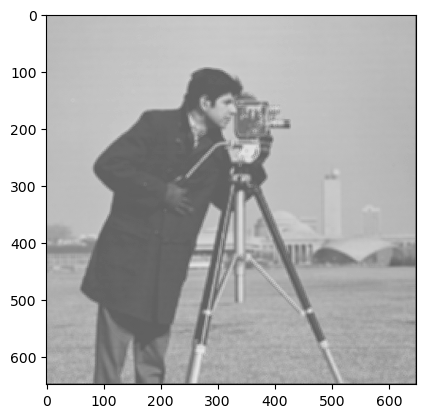

In [12]:
sharpened_image = laplace + image


plt.imshow(sharpened_image,cmap= 'gray')
plt.show()

In [20]:
def gaussian_kernel(size, sigma):
    """
    Generate a Gaussian kernel.

    Parameters:
        size (int): The size of the kernel (must be odd).
        sigma (float): The standard deviation of the Gaussian distribution.

    Returns:
        np.ndarray: A 2D Gaussian kernel.
    """
    # Ensure the size is odd
    if size % 2 == 0:
        raise ValueError("Kernel size must be odd.")

    # Define the range for the kernel (center at 0)
    k = size // 2
    x, y = np.meshgrid(np.arange(-k, k + 1), np.arange(-k, k + 1))


    # Compute the Gaussian function
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    # Normalize the kernel so the sum is 1
    kernel /= kernel.sum()

    return kernel

g_k = gaussian_kernel(3,1)

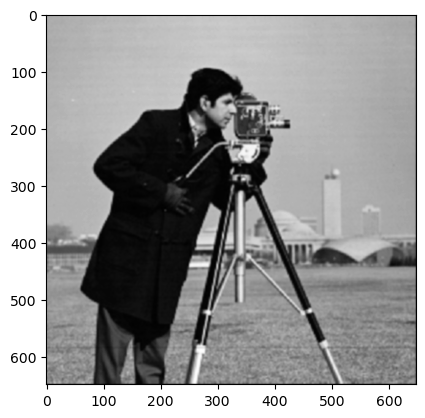

In [26]:
g_k = gaussian_kernel(7,1)
g_k_image = conv2d(image,g_k)

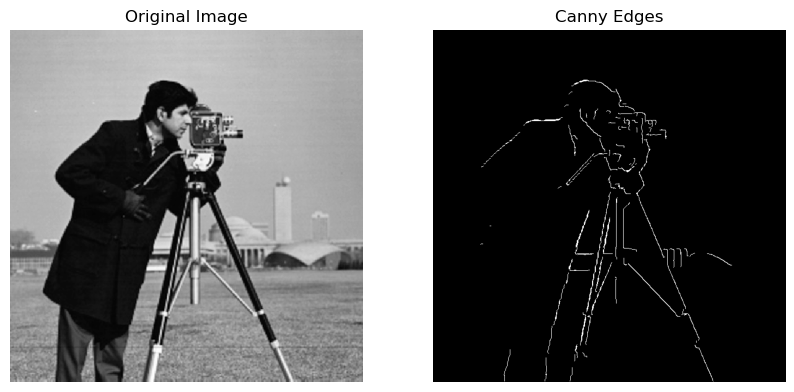

In [27]:
import numpy as np
import cv2

def gaussian_kernel(size, sigma):
    """
    Generate a Gaussian kernel.

    Parameters:
        size (int): The size of the kernel (must be odd).
        sigma (float): The standard deviation of the Gaussian distribution.

    Returns:
        np.ndarray: A 2D Gaussian kernel.
    """
    # Ensure the size is odd
    if size % 2 == 0:
        raise ValueError("Kernel size must be odd.")

    # Define the range for the kernel (center at 0)
    k = size // 2
    x, y = np.meshgrid(np.arange(-k, k + 1), np.arange(-k, k + 1))

    # Compute the Gaussian function
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))

    # Normalize the kernel so the sum is 1
    kernel /= kernel.sum()

    return kernel

def sobel_filters(image):
    """
    Apply Sobel filters to calculate gradients in x and y directions.

    Parameters:
        image (np.ndarray): Grayscale input image.

    Returns:
        G (np.ndarray): Gradient magnitude.
        theta (np.ndarray): Gradient direction.
    """
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

    Ix = cv2.filter2D(image, -1, Kx)
    Iy = cv2.filter2D(image, -1, Ky)

    G = np.hypot(Ix, Iy)  # Gradient magnitude
    G = G / G.max() * 255  # Normalize to 0-255
    theta = np.arctan2(Iy, Ix)  # Gradient direction

    return G, theta

def non_maximum_suppression(G, theta):
    """
    Thin edges using non-maximum suppression.

    Parameters:
        G (np.ndarray): Gradient magnitude.
        theta (np.ndarray): Gradient direction.

    Returns:
        np.ndarray: Thinned edges.
    """
    M, N = G.shape
    Z = np.zeros((M, N), dtype=np.float32)
    angle = theta * 180.0 / np.pi
    angle[angle < 0] += 180

    for i in range(1, M - 1):
        for j in range(1, N - 1):
            q = 255
            r = 255

            # Angle 0
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                q = G[i, j + 1]
                r = G[i, j - 1]
            # Angle 45
            elif 22.5 <= angle[i, j] < 67.5:
                q = G[i + 1, j - 1]
                r = G[i - 1, j + 1]
            # Angle 90
            elif 67.5 <= angle[i, j] < 112.5:
                q = G[i + 1, j]
                r = G[i - 1, j]
            # Angle 135
            elif 112.5 <= angle[i, j] < 157.5:
                q = G[i - 1, j - 1]
                r = G[i + 1, j + 1]

            if G[i, j] >= q and G[i, j] >= r:
                Z[i, j] = G[i, j]
            else:
                Z[i, j] = 0

    return Z

def double_threshold(img, low_threshold, high_threshold):
    """
    Apply double thresholding to classify strong, weak, and non-relevant pixels.

    Parameters:
        img (np.ndarray): Input image after non-maximum suppression.
        low_threshold (float): Low threshold value.
        high_threshold (float): High threshold value.

    Returns:
        np.ndarray: Thresholded image.
    """
    strong = 255
    weak = 50

    strong_i, strong_j = np.where(img >= high_threshold)
    weak_i, weak_j = np.where((img >= low_threshold) & (img < high_threshold))

    result = np.zeros_like(img, dtype=np.float32)
    result[strong_i, strong_j] = strong
    result[weak_i, weak_j] = weak

    return result

def edge_tracking_by_hysteresis(img):
    """
    Perform edge tracking by hysteresis to finalize edges.

    Parameters:
        img (np.ndarray): Image after double thresholding.

    Returns:
        np.ndarray: Final edges.
    """
    M, N = img.shape
    strong = 255
    weak = 50

    for i in range(1, M - 1):
        for j in range(1, N - 1):
            if img[i, j] == weak:
                if (strong in img[i - 1:i + 2, j - 1:j + 2]):
                    img[i, j] = strong
                else:
                    img[i, j] = 0

    return img

def canny_edge_detection(image, low_threshold, high_threshold):
    """
    Perform Canny edge detection.

    Parameters:
        image (np.ndarray): Input image.
        low_threshold (float): Low threshold value for double thresholding.
        high_threshold (float): High threshold value for double thresholding.

    Returns:
        np.ndarray: Detected edges.
    """
    # Step 1: Apply Gaussian blur
    blurred = cv2.filter2D(image, -1, gaussian_kernel(5, 1.4))

    # Step 2: Compute gradient magnitude and direction
    G, theta = sobel_filters(blurred)

    # Step 3: Non-maximum suppression
    suppressed = non_maximum_suppression(G, theta)

    # Step 4: Double thresholding
    thresholded = double_threshold(suppressed, low_threshold, high_threshold)

    # Step 5: Edge tracking by hysteresis
    edges = edge_tracking_by_hysteresis(thresholded)

    return edges

# Example usage
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    # Load image in grayscale

    # Perform Canny edge detection
    edges = canny_edge_detection(image, low_threshold=50, high_threshold=150)

    # Display the results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Canny Edges")
    plt.imshow(edges, cmap="gray")
    plt.axis("off")
    plt.show()


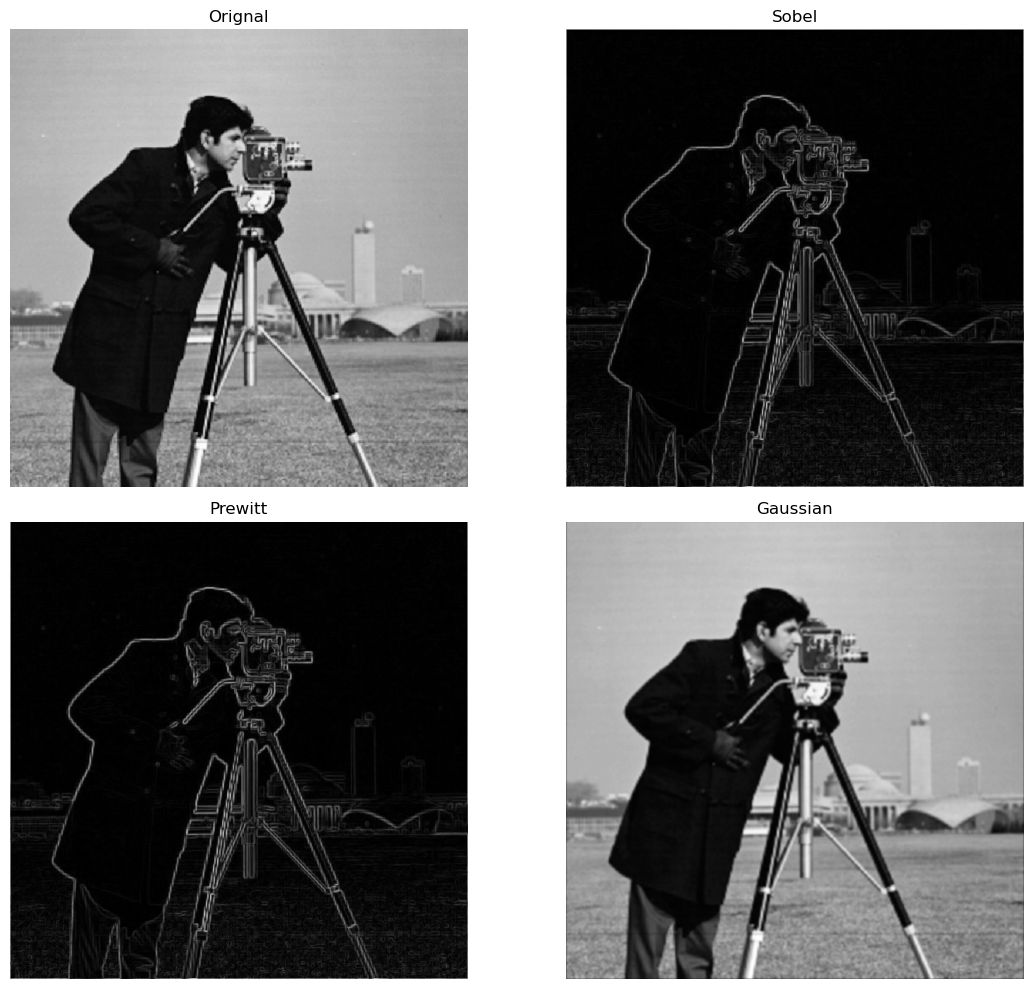

In [34]:
plt.figure(figsize=(12, 10))  # Set the figure size

plt.subplot(2,2,1)
plt.imshow(image,cmap='gray')
plt.title("Orignal")
plt.axis(False)
plt.subplot(2,2,2)
plt.imshow(sobel,cmap='gray')
plt.title("Sobel")
plt.axis(False)
plt.subplot(2,2,3)
plt.imshow(prewitt,cmap='gray')
plt.title("Prewitt")
plt.axis(False)
plt.subplot(2,2,4)
plt.imshow(g_k_image,cmap='gray')
plt.title("Gaussian")
plt.axis(False)
plt.tight_layout()
plt.show()
